# Problem set 3

In [1]:
from math import *
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

## Circular motion
Write a function in the class robot called move()

that takes self and a motion vector (this
motion vector contains a steering* angle and a
distance) as input and returns an instance of the class
robot with the appropriate x, y, and orientation
for the given motion.

*steering is defined in the video
which accompanies this problem.

For now, please do NOT add noise to your move function.

Please do not modify anything except where indicated
below.

There are test cases which you are free to use at the
bottom. If you uncomment them for testing, make sure you
re-comment them before you submit.

### Helper functions for visualising robot motion

In [2]:
def save_loc(robots):
    # save x and y locations and orientation to lists for easy plotting
    [x, y, ori] = zip(*[[r.x, r.y, r.orientation] for r in robots])
    return [list(x), list(y), list(ori)]

In [3]:
def line(x, y, theta, length):
    """
    Return X and Y coordinates of a line given start point (x, y),
    orientation theta (in radians), and length.
    """
    a = sin(theta) * length
    b = cos(theta) * length
    xa = x + b
    ya = y + a
    X = [x, xa]
    Y = [y, ya]
    return X, Y

In [4]:
# robot plotting function
def plot_robot(world_size, length, locs=None, landmarks=None, real_loc=None, clear_axes=False):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.close()
    ax.cla()

    if not locs:
        if not real_loc:
            raise(ValueError("At least one of locs or real_loc must be specified."))
        steps = len(real_loc)
    else:
        steps = len(locs)

    alpha_steps = range(steps + 1)[1:]

    for step in range(steps):
    
        # marker transparency
        alpha = alpha_steps[step] / steps
        if clear_axes:
            alpha = 1.0

        if clear_axes:
            ax.cla()

        if locs:
            ax.plot(locs[step][0], locs[step][1], '.', color='blue', alpha=alpha)

        if landmarks:
            for landmark in landmarks:
                ax.plot(landmark[1], landmark[0], 's', color='red')

        if real_loc:
            try:
                [x], [y], [theta] = real_loc[step]
            except IndexError:
                # if there is no newer location for the real robot,
                # plot the last known location after moving
                [x], [y], [theta] = real_loc[-1]

            # start- and endpoint of the robot body (line)
            X, Y = line(x, y, theta, length)
            ax.plot(X, Y, '-', color='green', alpha=alpha)
        
        ax.axis("square")
        ax.set_title("Robot position")
        display(fig)
        
        clear_output(wait = True)
        plt.pause(0.5)

### Robot class

In [5]:
class robot:

    def __init__(self, length=10.0, max_steering_angle=pi/4):
        self.x = random.random() * world_size # initial x position
        self.y = random.random() * world_size # initial y position
        self.orientation = random.random() * 2.0 * pi # initial orientation
        self.length = length # length of robot
        self.bearing_noise  = 0.0 # initialize bearing noise to zero
        self.steering_noise = 0.0 # initialize steering noise to zero
        self.distance_noise = 0.0 # initialize distance noise to zero
        self.max_steering_angle = max_steering_angle
    
    def __repr__(self):
        return '[x=%.6s y=%.6s orient=%.6s]' % (str(self.x), str(self.y), str(self.orientation))

    def set(self, new_x, new_y, new_orientation):
        if new_orientation < 0 or new_orientation >= 2 * pi:
            raise ValueError('Orientation must be in [0..2pi]')
        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation)

    def set_noise(self, new_b_noise, new_s_noise, new_d_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.bearing_noise  = float(new_b_noise)
        self.steering_noise = float(new_s_noise)
        self.distance_noise = float(new_d_noise)
    
    ############# ONLY ADD/MODIFY CODE BELOW HERE ###################

    def move(self, motion, tolerance=0.001):
        # steering angle
        alpha = random.gauss(motion[0], self.steering_noise)
        distance = random.gauss(motion[1], self.distance_noise)
        # turning angle
        beta = (distance / self.length) * tan(alpha)
        # current orientation
        theta = self.orientation

        # check maximum angle that the wheels can turn
        if abs(alpha) > self.max_steering_angle:
            raise(ValueError("Exceeded maximum steering angle."))

        # turn smaller than tolerance is considered linear motion
        if abs(alpha) < tolerance:
            x_new = self.x + distance * cos(theta)
            y_new = self.y + distance * sin(theta)
        # turning motion
        else:
            radius = distance / beta
            cx = self.x - sin(theta) * radius
            cy = self.y + cos(theta) * radius
            x_new = cx + sin(theta + beta) * radius
            y_new = cy - cos(theta + beta) * radius

        theta_new = (theta + beta) % (2 * pi)
        
        # set particle
        result = robot(self.length)
        result.set(x_new, y_new, theta_new)
        return result # make sure your move function returns an instance
                      # of the robot class with the correct coordinates.

    def sense(self):
        Z = []
        for landmark in landmarks:
            dy = landmark[0] - self.y
            dx = landmark[1] - self.x
            bearing = atan2(dy, dx) - self.orientation
            # bearing should be in domain (0, 2pi)
            if bearing < 0:
                bearing = 2 * pi + bearing
            bearing = random.gauss(bearing, self.bearing_noise)
            Z.append(bearing)
        return Z
   

In [6]:
# the "world" has 4 landmarks.
# the robot's initial coordinates are somewhere in the square
# represented by the landmarks.
#
# NOTE: Landmark coordinates are given in (y, x) form and NOT
# in the traditional (x, y) format!

landmarks  = [[0.0, 100.0], [0.0, 0.0], [100.0, 0.0], [100.0, 100.0]]
world_size = 100.0 # world is NOT cyclic. Robot is allowed to travel "out of bounds"
max_steering_angle = pi/4 # You don't need to use this value, but it is good to keep in mind the limitations of a real car.


### Test case 1

In [7]:
# TEST CASE:
# 
# 1) The following code should print:
#       Robot:     [x=0.0 y=0.0 orient=0.0]
#       Robot:     [x=10.0 y=0.0 orient=0.0]
#       Robot:     [x=19.861 y=1.4333 orient=0.2886]
#       Robot:     [x=39.034 y=7.1270 orient=0.2886]

length = 20.
bearing_noise  = 0.0
steering_noise = 0.0
distance_noise = 0.0

myrobot = robot(length)
myrobot.set(0.0, 0.0, 0.0)
myrobot.set_noise(bearing_noise, steering_noise, distance_noise)

# save robot location
real_loc = []
real_loc.append(save_loc([myrobot]))

motions = [[0.0, 10.0], [pi / 6.0, 10], [0.0, 20.0]]

T = len(motions)

print('Robot:    ', myrobot)
for t in range(T):
   myrobot = myrobot.move(motions[t])
   real_loc.append(save_loc([myrobot]))
   print('Robot:    ', myrobot)

Robot:     [x=0.0 y=0.0 orient=0.0]
Robot:     [x=10.0 y=0.0 orient=0.0]
Robot:     [x=19.861 y=1.4333 orient=0.2886]
Robot:     [x=39.034 y=7.1270 orient=0.2886]


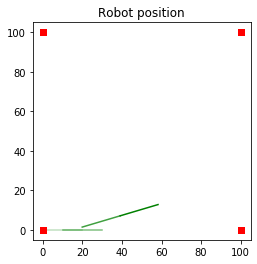

In [8]:
plot_robot(world_size, length, locs=None, landmarks=landmarks, real_loc=real_loc, clear_axes=False)

### Test case 2

In [9]:
# 2) The following code should print:
#      Robot:     [x=0.0 y=0.0 orient=0.0]
#      Robot:     [x=9.9828 y=0.5063 orient=0.1013]
#      Robot:     [x=19.863 y=2.0201 orient=0.2027]
#      Robot:     [x=29.539 y=4.5259 orient=0.3040]
#      Robot:     [x=38.913 y=7.9979 orient=0.4054]
#      Robot:     [x=47.887 y=12.400 orient=0.5067]
#      Robot:     [x=56.369 y=17.688 orient=0.6081]
#      Robot:     [x=64.273 y=23.807 orient=0.7094]
#      Robot:     [x=71.517 y=30.695 orient=0.8108]
#      Robot:     [x=78.027 y=38.280 orient=0.9121]
#      Robot:     [x=83.736 y=46.485 orient=1.0135]

length = 20.
bearing_noise  = 0.0
steering_noise = 0.0
distance_noise = 0.0

myrobot = robot(length)
myrobot.set(0.0, 0.0, 0.0)
myrobot.set_noise(bearing_noise, steering_noise, distance_noise)

# save robot location
real_loc = []
real_loc.append(save_loc([myrobot]))

motions = [[0.2, 10.] for row in range(10)]

T = len(motions)

print('Robot:    ', myrobot)
for t in range(T):
   myrobot = myrobot.move(motions[t])
   real_loc.append(save_loc([myrobot]))
   print('Robot:    ', myrobot)

Robot:     [x=0.0 y=0.0 orient=0.0]
Robot:     [x=9.9828 y=0.5063 orient=0.1013]
Robot:     [x=19.863 y=2.0201 orient=0.2027]
Robot:     [x=29.539 y=4.5259 orient=0.3040]
Robot:     [x=38.913 y=7.9979 orient=0.4054]
Robot:     [x=47.887 y=12.400 orient=0.5067]
Robot:     [x=56.369 y=17.688 orient=0.6081]
Robot:     [x=64.273 y=23.807 orient=0.7094]
Robot:     [x=71.517 y=30.695 orient=0.8108]
Robot:     [x=78.027 y=38.280 orient=0.9121]
Robot:     [x=83.736 y=46.485 orient=1.0135]


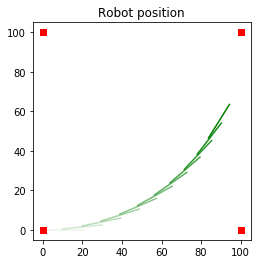

In [10]:
plot_robot(world_size, length, locs=None, landmarks=landmarks, real_loc=real_loc, clear_axes=False)

## Sensing
Write a function in the class robot called sense()
that takes self as input
and returns a list, Z, of the four bearings* to the 4
different landmarks. you will have to use the robot's
x and y position, as well as its orientation, to
compute this.

*bearing is defined in the video
which accompanies this problem.

For now, please do NOT add noise to your sense function.

Please do not modify anything except where indicated
below.

There are test cases provided at the bottom which you are
free to use. If you uncomment any of these cases for testing
make sure that you re-comment it before you submit.

In [11]:
# the "world" has 4 landmarks.
# the robot's initial coordinates are somewhere in the square
# represented by the landmarks.
#
# NOTE: Landmark coordinates are given in (y, x) form and NOT
# in the traditional (x, y) format!

landmarks  = [[0.0, 100.0], [0.0, 0.0], [100.0, 0.0], [100.0, 100.0]] # position of 4 landmarks in (y, x) form.
world_size = 100.0 # world is NOT cyclic. Robot is allowed to travel "out of bounds"

### Test case 1

In [12]:
# 1) The following code should print the list
# [6.004885648174475, 3.7295952571373605, 1.9295669970654687, 0.8519663271732721]

length = 20.
bearing_noise  = 0.0
steering_noise = 0.0
distance_noise = 0.0

myrobot = robot(length)
myrobot.set(30.0, 20.0, 0.0)
myrobot.set_noise(bearing_noise, steering_noise, distance_noise)

print('Robot:        ', myrobot)
print('Measurements: ', myrobot.sense())

Robot:         [x=30.0 y=20.0 orient=0.0]
Measurements:  [6.004885648174475, 3.7295952571373605, 1.9295669970654687, 0.8519663271732721]


### Test case 2

In [13]:
# 2) The following code should print the list
# [5.376567117456516, 3.101276726419402, 1.3012484663475101, 0.22364779645531352]

length = 20.
bearing_noise  = 0.0
steering_noise = 0.0
distance_noise = 0.0

myrobot = robot(length)
myrobot.set(30.0, 20.0, pi / 5.0)
myrobot.set_noise(bearing_noise, steering_noise, distance_noise)

print('Robot:        ', myrobot)
print('Measurements: ', myrobot.sense())

Robot:         [x=30.0 y=20.0 orient=0.6283]
Measurements:  [5.376567117456516, 3.101276726419402, 1.3012484663475101, 0.22364779645531352]


## Adding the noise
Now you will put everything together.

First make sure that your sense and move functions
work as expected for the test cases provided at the
bottom of the previous two programming assignments.
Once you are satisfied, copy your sense and move
definitions into the robot class on this page, BUT
now include noise.

A good way to include noise in the sense step is to
add Gaussian noise, centered at zero with variance
of self.bearing_noise to each bearing. You can do this
with the command random.gauss(0, self.bearing_noise)

In the move step, you should make sure that your
actual steering angle is chosen from a Gaussian
distribution of steering angles. This distribution
should be centered at the intended steering angle
with variance of self.steering_noise.

Feel free to use the included set_noise function.

In [14]:
max_steering_angle = pi / 4.0 # You do not need to use this value, but keep in mind the limitations of a real car.
bearing_noise = 0.1 # Noise parameter: should be included in sense function.
steering_noise = 0.1 # Noise parameter: should be included in move function.
distance_noise = 5.0 # Noise parameter: should be included in move function.

tolerance_xy = 15.0 # Tolerance for localization in the x and y directions.
tolerance_orientation = 0.25 # Tolerance for orientation.

landmarks  = [[0.0, 100.0], [0.0, 0.0], [100.0, 0.0], [100.0, 100.0]] # position of 4 landmarks in (y, x) format.
world_size = 100.0 # world is NOT cyclic. Robot is allowed to travel "out of bounds"

In [15]:
class robot:

    # --------
    # init: 
    #    creates robot and initializes location/orientation 
    #

    def __init__(self, length = 20.0):
        self.x = random.random() * world_size # initial x position
        self.y = random.random() * world_size # initial y position
        self.orientation = random.random() * 2.0 * pi # initial orientation
        self.length = length # length of robot
        self.bearing_noise  = 0.0 # initialize bearing noise to zero
        self.steering_noise = 0.0 # initialize steering noise to zero
        self.distance_noise = 0.0 # initialize distance noise to zero

    # --------
    # set: 
    #    sets a robot coordinate
    #

    def set(self, new_x, new_y, new_orientation):

        if new_orientation < 0 or new_orientation >= 2 * pi:
            raise(ValueError, 'Orientation must be in [0..2pi]')
        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation)

    # --------
    # set_noise: 
    #    sets the noise parameters
    #
    def set_noise(self, new_b_noise, new_s_noise, new_d_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.bearing_noise  = float(new_b_noise)
        self.steering_noise = float(new_s_noise)
        self.distance_noise = float(new_d_noise)

    # --------
    # measurement_prob
    #    computes the probability of a measurement
    #  

    def measurement_prob(self, measurements):

        # calculate the correct measurement
        predicted_measurements = self.sense(0) # Our sense function took 0 as an argument to switch off noise.


        # compute errors
        error = 1.0
        for i in range(len(measurements)):
            error_bearing = abs(measurements[i] - predicted_measurements[i])
            error_bearing = (error_bearing + pi) % (2.0 * pi) - pi # truncate
            

            # update Gaussian
            error *= (exp(- (error_bearing ** 2) / (self.bearing_noise ** 2) / 2.0) /  
                      sqrt(2.0 * pi * (self.bearing_noise ** 2)))

        return error
    
    def __repr__(self): #allows us to print robot attributes.
        return '[x=%.6s y=%.6s orient=%.6s]' % (str(self.x), str(self.y), 
                                                str(self.orientation))
    
    ############# ONLY ADD/MODIFY CODE BELOW HERE ###################
       
    # --------
    # move: 
    #   
    
    # copy your code from the previous exercise
    # and modify it so that it simulates motion noise
    # according to the noise parameters
    #           self.steering_noise
    #           self.distance_noise

    def move(self, motion, tolerance=0.001):
        # steering angle
        alpha = random.gauss(motion[0], self.steering_noise)
        distance = random.gauss(motion[1], self.distance_noise)
        # turning angle
        beta = (distance / self.length) * tan(alpha)
        # current orientation
        theta = self.orientation

        # # check maximum angle that the wheels can turn
        # if abs(alpha) > max_steering_angle:
        #     raise(ValueError("Exceeded maximum steering angle."))

        # turn smaller than tolerance is considered linear motion
        if abs(alpha) < tolerance:
            x_new = self.x + distance * cos(theta)
            y_new = self.y + distance * sin(theta)
        # turning motion
        else:
            radius = distance / beta
            cx = self.x - sin(theta) * radius
            cy = self.y + cos(theta) * radius
            x_new = cx + sin(theta + beta) * radius
            y_new = cy - cos(theta + beta) * radius

        theta_new = (theta + beta) % (2 * pi)
        
        # set particle
        result = robot(self.length)
        result.set(x_new, y_new, theta_new)
        result.set_noise(self.bearing_noise, self.steering_noise, self.distance_noise)
        return result

    # --------
    # sense: 
    #    

    # copy your code from the previous exercise
    # and modify it so that it simulates bearing noise
    # according to
    #           self.bearing_noise

    def sense(self, noise=True):
        Z = []
        for landmark in landmarks:
            dy = landmark[0] - self.y
            dx = landmark[1] - self.x
            bearing = atan2(dy, dx) - self.orientation
            # bearing should be in domain (0, 2pi)
            if bearing < 0:
                bearing = 2 * pi + bearing
            if noise:
                bearing = random.gauss(bearing, self.bearing_noise)
            Z.append(bearing)
        return Z

    ############## ONLY ADD/MODIFY CODE ABOVE HERE ####################

In [16]:
# --------
#
# extract position from a particle set
# 

def get_position(p):
    x = 0.0
    y = 0.0
    orientation = 0.0
    for i in range(len(p)):
        x += p[i].x
        y += p[i].y
        # orientation is tricky because it is cyclic. By normalizing
        # around the first particle we are somewhat more robust to
        # the 0=2pi problem
        orientation += (((p[i].orientation - p[0].orientation + pi) % (2.0 * pi)) 
                        + p[0].orientation - pi)
    return [x / len(p), y / len(p), orientation / len(p)]

# --------
#
# The following code generates the measurements vector
# You can use it to develop your solution.
# 


def generate_ground_truth(motions):

    myrobot = robot()
    myrobot.set_noise(bearing_noise, steering_noise, distance_noise)

    Z = []
    T = len(motions)

    for t in range(T):
        myrobot = myrobot.move(motions[t])
        Z.append(myrobot.sense())
    #print 'Robot:    ', myrobot
    return [myrobot, Z]

# --------
#
# The following code prints the measurements associated
# with generate_ground_truth
#

def print_measurements(Z):

    T = len(Z)

    print('measurements = [[%.8s, %.8s, %.8s, %.8s],' % \
        (str(Z[0][0]), str(Z[0][1]), str(Z[0][2]), str(Z[0][3])))
    for t in range(1,T-1):
        print('                [%.8s, %.8s, %.8s, %.8s],' % \
            (str(Z[t][0]), str(Z[t][1]), str(Z[t][2]), str(Z[t][3])))
    print('                [%.8s, %.8s, %.8s, %.8s]]' % \
        (str(Z[T-1][0]), str(Z[T-1][1]), str(Z[T-1][2]), str(Z[T-1][3])))

# --------
#
# The following code checks to see if your particle filter
# localizes the robot to within the desired tolerances
# of the true position. The tolerances are defined at the top.
#

def check_output(final_robot, estimated_position):

    error_x = abs(final_robot.x - estimated_position[0])
    error_y = abs(final_robot.y - estimated_position[1])
    error_orientation = abs(final_robot.orientation - estimated_position[2])
    error_orientation = (error_orientation + pi) % (2.0 * pi) - pi
    correct = error_x < tolerance_xy and error_y < tolerance_xy \
              and error_orientation < tolerance_orientation
    return correct



def particle_filter(motions, measurements, N=500): # I know it's tempting, but don't change N!
    # --------
    #
    # Make particles
    # 

    p = []
    for i in range(N):
        r = robot()
        r.set_noise(bearing_noise, steering_noise, distance_noise)
        p.append(r)

    # --------
    #
    # Update particles
    #     

    for t in range(len(motions)):
    
        # motion update (prediction)
        p2 = []
        for i in range(N):
            p2.append(p[i].move(motions[t]))
        p = p2

        # measurement update
        w = []
        for i in range(N):
            w.append(p[i].measurement_prob(measurements[t]))

        # resampling
        p3 = []
        index = int(random.random() * N)
        beta = 0.0
        mw = max(w)
        for i in range(N):
            beta += random.random() * 2.0 * mw
            while beta > w[index]:
                beta -= w[index]
                index = (index + 1) % N
            p3.append(p[index])
        p = p3
    
    return get_position(p)

### Test case 1

In [17]:
#1) Calling the particle_filter function with the following
#    motions and measurements should return a [x,y,orientation]
#    vector near [x=93.476 y=75.186 orient=5.2664], that is, the
#    robot's true location.

motions = [[2. * pi / 10, 20.] for row in range(8)]
measurements = [[4.746936, 3.859782, 3.045217, 2.045506],
               [3.510067, 2.916300, 2.146394, 1.598332],
               [2.972469, 2.407489, 1.588474, 1.611094],
               [1.906178, 1.193329, 0.619356, 0.807930],
               [1.352825, 0.662233, 0.144927, 0.799090],
               [0.856150, 0.214590, 5.651497, 1.062401],
               [0.194460, 5.660382, 4.761072, 2.471682],
               [5.717342, 4.736780, 3.909599, 2.342536]]

print(particle_filter(motions, measurements))

[94.23117510586133, 71.6721497533323, 5.302018144421218]


### Test case 2

In [18]:
# 2) You can generate your own test cases by generating
#    measurements using the generate_ground_truth function.
#    It will print the robot's last location when calling it.

number_of_iterations = 6
motions = [[2. * pi / 20, 12.] for row in range(number_of_iterations)]

x = generate_ground_truth(motions)
final_robot = x[0]
measurements = x[1]
estimated_position = particle_filter(motions, measurements)
print_measurements(measurements)
print('Ground truth:    ', final_robot)
print('Particle filter: ', estimated_position)
print('Code check:      ', check_output(final_robot, estimated_position))

measurements = [[0.781837, -0.78742, 3.495869, 2.020383],
                [0.746177, -1.07948, 3.319856, 1.888188],
                [0.593839, -1.59287, 2.824085, 1.799306],
                [0.324684, -1.91711, 2.793159, 1.783976],
                [0.267062, -2.46324, 2.584461, 1.768148],
                [0.164866, -2.70170, 2.465333, 1.633710]]
Ground truth:     [x=69.022 y=6.6383 orient=5.9464]
Particle filter:  [57.956153778452375, 1.2006658918654805, 5.91545607694734]
Code check:       True
